## Import library and prepare the data.


#Fit deep neural networks


In [ ]:
# Importing the necessary packages and the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
# import nsp as nsp
import pdb
# Load matplotlib images inline
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

   
# %autoreload 2
# data = sio.loadmat('JR_2015-12-04_truncated2.mat') # load the .mat file.
# R = data['R'][0,:]

def PlotSpikeRaster(S):
    gap = 3
    mark = 5
    pad = 30

    numSpikeTrains = np.size(S);
    for s in range(numSpikeTrains):
        offset = pad + gap + s*(gap+mark)
        train = S[s]
        if np.size(train)!=0 :
            train = train[:]
            for t in train.T :
                plt.plot([t,t], [offset, offset+mark], color=[0,0,0])

    plt.xlabel('Time (ms)')
    plt.ylim([0,offset+mark+gap+pad])
    
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int(np.ceil(window_len/2-1)):int(np.ceil(-(window_len/2)))] 



def bin(X, binWidth,binType):
    [dims,numSamples] = X.shape
    if binType == 'first':
        numBins = np.ceil(float(numSamples)/binWidth).astype(int)
    else:
        numBins = np.floor(float(numSamples)/binWidth).astype(int)
    
    binX = np.zeros((dims, numBins),dtype = list)
    
    for i in range(numBins):
        binStart = i*binWidth
        binStop  = (i+1)*binWidth
        if binType == 'sum' :
            binX[:,i] = np.sum(X[:, binStart : binStop].todense(), 1).T
        elif binType == 'mean' :
            binX[:,i] = np.mean(X[:, binStart : binStop].todense(), 1).T
        elif binType ==  'first':
            binX[:,i] = np.asarray(X[:,binStart].todense().T)
        elif binType ==  'last':
            binX[:,i] = X[:, binStop]        
    return binX
  
  
 

In [ ]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
mat_import = drive.CreateFile({'id':'1FzNddiUdjTa-aNdAdxsy3jdR9zp9d4EC'})
mat_import.GetContentFile('sample.mat') # - 'sample.json' is the file name that will be accessible in the notebook
# print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
data = sio.loadmat('sample.mat') # load the .mat file.
R = data['R'][0,:]

##Data preprocessing for FC neural network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
import pandas as pd



Using TensorFlow backend.


In [ ]:
train_num = 400
dt = 25
Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X = scipy.sparse.csc_matrix(X)
Y_bin = bin(Y, dt,'sum').astype('float')
X_bin = bin(X, dt,'first').astype('float')
X_bin = np.matrix(np.diff(X_bin[0:2,:])/dt*1000, dtype = 'float')

lookback = 3
Y1= np.matrix(Y_bin[:,lookback:],dtype= float)
Y2 =np.matrix(Y_bin[:,lookback-1:-lookback+2],dtype= float)
Y3 =np.matrix(Y_bin[:,lookback-2:-lookback+1],dtype= float)
Y4 =np.matrix(Y_bin[:,lookback-3:-lookback],dtype= float)
Y_large = np.vstack((Y1,Y2,Y3,Y4))
X_train_t = pd.DataFrame(Y_large.T)
y_train = pd.DataFrame(X_bin[:,3:].T)

Y =scipy.sparse.hstack(R[train_num:]['spikeRaster'])
X =scipy.sparse.hstack(R[train_num:]['cursorPos'])
X = scipy.sparse.csc_matrix(X)
Y_bin = bin(Y, dt,'sum').astype('float')
X_bin = bin(X, dt,'first').astype('float')
X_bin = np.matrix(np.diff(X_bin[0:2,:])/dt*1000, dtype = 'float')
Y1= np.matrix(Y_bin[:,lookback:],dtype= float)
Y2 =np.matrix(Y_bin[:,lookback-1:-lookback+2],dtype= float)
Y3 =np.matrix(Y_bin[:,lookback-2:-lookback+1],dtype= float)
Y4 =np.matrix(Y_bin[:,lookback-3:-lookback],dtype= float)
Y_large = np.vstack((Y1,Y2,Y3,Y4))

X_test_t = pd.DataFrame(Y_large.T)
y_test = pd.DataFrame(X_bin[:,3:].T)


In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(18, input_dim=X_train_t.shape[1], activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                6930      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               3800      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 211,832
Trainable params: 211,832
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history =  model.fit(X_train_t, y_train, epochs=300,
                     validation_split=0.1,
                     batch_size=1024, verbose=0
                    )
#                     ,callbacks=[early_stop])

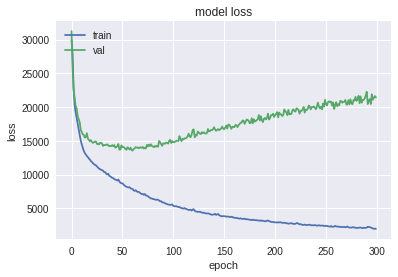

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.predict(X_train_t)
print('training loss: {}'.format(model.evaluate(X_train_t, y_train)))
# X_train_t.shape
# print('==========\n')
print('testing loss: {}'.format(model.evaluate(X_test_t, y_test)))


16462/16462 [==============================] - 1s 59us/step
training loss: 3860.930775595702
4328/4328 [==============================] - 0s 57us/step
testing loss: 21553.132451930018


###Plot the trajectory

(-150, 150)

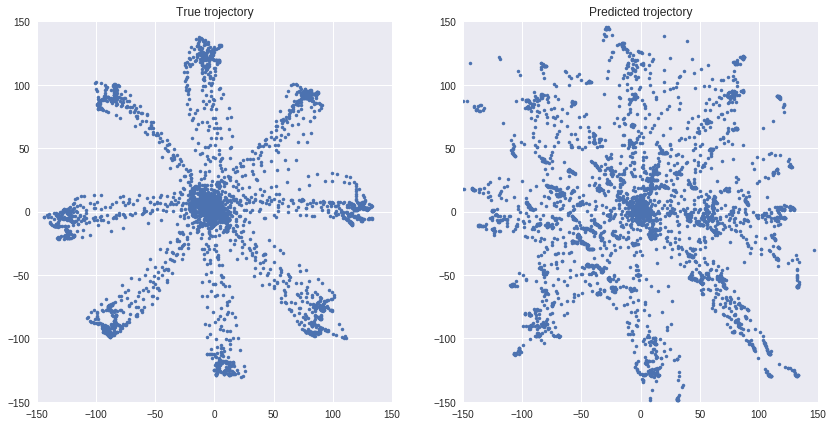

In [ ]:
plt.figure(figsize=(7,7))

X_bin_poss = np.empty((2,0))
X_bin_pos_hats = np.empty((2,0))
test_num = 106



for i in range(test_num):
  X = R[train_num + i]['cursorPos']
  X = scipy.sparse.csc_matrix(X)
  X_bin_pos = bin(X, dt,'first')
  X_bin_v = np.matrix(np.diff(X_bin_pos[0:2,:])/dt*1000, dtype = 'float')

  num_bin = X_bin_pos.shape[1]
  X_bin_pos = X_bin_pos[0:2,0:num_bin]
  if X.shape[1]%dt == 0:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin]])
  else:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin-1]])
  
  Y = R[train_num+i]['spikeRaster']
  Y_bin = bin(Y, dt,'sum')
  pre_Y = R[train_num-1+i]['spikeRaster']
  pre_Y_bin = bin(pre_Y, dt,'sum')
#     Y1 =np.hstack([last_Y_bin[:,-3:]Y_bin[:,3:],)

  Y1 =np.matrix(Y_bin, dtype = float)
  Y2 =np.hstack([pre_Y_bin[:,-1:], Y_bin[:,:-1]])
  Y3 =np.hstack([pre_Y_bin[:,-2:], Y_bin[:,:-2]])
  Y4 =np.hstack([pre_Y_bin[:,-3:], Y_bin[:,:-3]])
  Y_large = np.vstack((Y1,Y2,Y3,Y4))

  X_bin_v_hat = model.predict(Y_large.T)
  X_bin_v_hat = X_bin_v_hat.T
  num_bins = X_bin_v_hat.shape[1]
  X_bin_pos_hat = np.empty((2,num_bins+1))

  X_bin_pos_hat[:,0] = R[train_num+i]['cursorPos'][0:2,0]
  for j in range(num_bins):
    X_bin_pos_hat[:,j+1] = X_bin_pos_hat[:,j] + \
                  0.025*np.array(X_bin_v_hat[0:2,j]).flatten()
  X_bin_pos_hat
  X_bin_pos_hats = np.hstack([X_bin_pos_hats, X_bin_pos_hat[:,0:num_bins]])

f, axs = plt.subplots(1,2,figsize=(14,7))
axs[0].plot(X_bin_poss[0,:],X_bin_poss[1,:], '.')
axs[0].set_title('True trojectory')
axs[0].set_xlim([-150, 150])
axs[0].set_ylim([-150, 150])

axs[1].plot(X_bin_pos_hats[0,:],X_bin_pos_hats[1,:], '.')
axs[1].set_title('Predicted trojectory')
axs[1].set_xlim([-150, 150])
axs[1].set_ylim([-150, 150])


In [ ]:
#====================================================#
# YOUR CODE HERE:
#   Calculate the mean-squared error between the decoded
#   hand position and the true hand position.  Average
#   the squared errors across time; then average the squared
#   errors across trials.
#====================================================#
pass
train_num = 400
test_num = 106
dt = 25
pos_errors = []

for i in range(test_num):
  X = R[train_num + i]['cursorPos']
  X = scipy.sparse.csc_matrix(X)
  X_bin_pos = bin(X, dt,'first')
  num_bin = X_bin_pos.shape[1]
  X_bin_pos = X_bin_pos[0:2,0:num_bin]

# prepare Y_bin
  Y = R[train_num+i]['spikeRaster']
  Y_bin = bin(Y, dt,'sum')
  pre_Y = R[train_num-1+i]['spikeRaster']
  pre_Y_bin = bin(pre_Y, dt,'sum')

  Y1 =np.matrix(Y_bin, dtype = float)
  Y2 =np.hstack([pre_Y_bin[:,-1:], Y_bin[:,:-1]])
  Y3 =np.hstack([pre_Y_bin[:,-2:], Y_bin[:,:-2]])
  Y4 =np.hstack([pre_Y_bin[:,-3:], Y_bin[:,:-3]])
  Y_large = np.vstack((Y1,Y2,Y3,Y4))
  Y_bin_test = np.vstack((Y_large,np.ones(np.size(Y_large,1))))

# predict velocity
  X_bin_v_hat = model.predict(Y_large.T)
  X_bin_v_hat = X_bin_v_hat.T
  num_bins = X_bin_v_hat.shape[1]
  X_bin_pos_hat = np.empty((2,num_bins+1))
  
  X_bin_pos_hat[:,0] = R[train_num+i]['cursorPos'][0:2,0]
  for j in range(num_bins):
    X_bin_pos_hat[:,j+1] = X_bin_pos_hat[:,j] \
                                + 0.025*np.array(X_bin_v_hat[0:2,j]).flatten()
  diff_trial = (X_bin_pos[:,0:num_bin] - X_bin_pos_hat[:,0:num_bin])
  pos_errors.append(np.mean(np.sum(np.power(diff_trial,2),axis = 0)))
np.mean(pos_errors)


#====================================================#
# END YOUR CODE
#====================================================#  

1650.024438023837

##LSTM

### Preprocessing for RNN

In [ ]:
from keras.layers import LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler

In [ ]:
lookback = 3
train_num = 400
dt = 25
Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X = scipy.sparse.csc_matrix(X)
Y_bin = bin(Y, dt,'sum').astype('float')
X_bin = bin(X, dt,'first').astype('float')
X_bin = np.matrix(np.diff(X_bin[0:2,:])/dt*1000, dtype = 'float')
# scalar = MinMaxScaler()
# scalar.fit(X_bin)
# X_bin = scalar.transform(X_bin)

def reformatinginput_for_rnn(Y_bin, X_bin_in, lookback, pre_Y_bin = 0):
  """reshape data input to the required format for 
  LSTM (sample_num, timestep, feature+numver)"""
  fea_num = Y_bin.shape[0]
  sample_num = Y_bin.shape[1]
  flag = 0
  if np.sum(pre_Y_bin)== 0:
    flag = 1
    pre_Y_bin = np.zeros((fea_num, lookback+1))
    
  X_reformed = np.empty((sample_num, lookback+1, fea_num))
  
  Y1 =np.matrix(Y_bin, dtype = float)
  Y2 =np.hstack([pre_Y_bin[:,-1:], Y_bin[:,:-1]])
  Y3 =np.hstack([pre_Y_bin[:,-2:], Y_bin[:,:-2]])
  Y4 =np.hstack([pre_Y_bin[:,-3:], Y_bin[:,:-3]])
  Y_large = np.vstack((Y1,Y2,Y3,Y4))
  
  for i in range(sample_num):
    for j in range(lookback+1):
      X_reformed[i,j,:] = Y_large[j*fea_num:(j+1)*fea_num,i].T
  if flag:
    X_reformed = np.delete(X_reformed, np.s_[:lookback:1], 0)
    y_reformed = X_bin_in[:, :-lookback].T
  else:
    y_reformed = X_bin_in
  return X_reformed, y_reformed

# reshape the one long oberservation into multiple episode.
X_train_rnn, y_train_rnn= reformatinginput_for_rnn(Y_bin, X_bin, 3)


# Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
# X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])

# X_train_rnn_nobin, y_train_rnn_nobin= reformatinginput_for_rnn(np.array(Y), np.array(X), 50)


###Define the LSTM model.

In [ ]:
K.clear_session()

dropout_rate = 0.6
model = Sequential()
model.add(LSTM(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate, return_sequences = True))
model.add(LSTM(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate, return_sequences = True))
model.add(LSTM(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate, return_sequences = True))
model.add(LSTM(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(4, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = ['accuracy'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 256)            361472    
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 256)            525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 256)            525312    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               128500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
__________

Train on 14815 samples, validate on 1647 samples
Epoch 1/200
14815/14815 [==============================] - 6s 381us/step - loss: 30018.9811 - val_loss: 31991.8109
Epoch 2/200
14815/14815 [==============================] - 1s 100us/step - loss: 30014.3278 - val_loss: 31944.3240
Epoch 3/200
14815/14815 [==============================] - 1s 100us/step - loss: 29591.5686 - val_loss: 29116.9728
Epoch 4/200
14815/14815 [==============================] - 1s 99us/step - loss: 28652.2673 - val_loss: 27402.4120
Epoch 5/200
14815/14815 [==============================] - 1s 99us/step - loss: 27777.2704 - val_loss: 26726.1732
Epoch 6/200
14815/14815 [==============================] - 2s 102us/step - loss: 27368.2070 - val_loss: 25524.4228
Epoch 7/200
14815/14815 [==============================] - 1s 100us/step - loss: 26522.3510 - val_loss: 23309.8446
Epoch 8/200
14815/14815 [==============================] - 1s 100us/step - loss: 25941.0342 - val_loss: 22791.2802
Epoch 9/200
14815/14815 [========

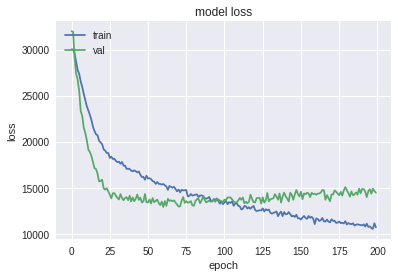

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

history = model.fit(X_train_rnn, y_train_rnn,
          epochs=200, batch_size=512*2,validation_split= 0.1, verbose=1)
#           ,callbacks=[early_stop])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.predict(X_train_t)
print('training loss: {}'.format(model.evaluate(X_train_rnn, y_train_rnn)))
# X_train_t.shape
# print('==========\n')
# print('testing loss: {}'.format(model.evaluate(X_test_rnn, y_test_rnn)))


16462/16462 [==============================] - 8s 461us/step
training loss: 5533.787619242125


The mean square error of cursor position: 2153.9084880002215


Text(0.5,1,'Predicted trojectory')

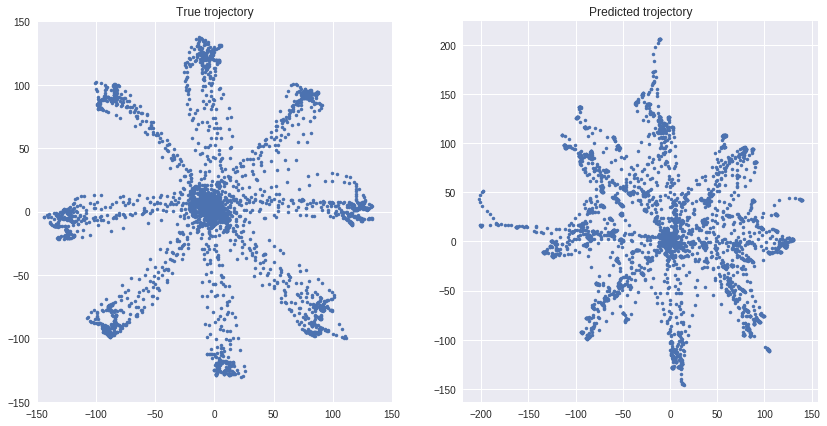

In [ ]:
plt.figure(figsize=(7,7))

X_bin_poss = np.empty((2,0))
X_bin_pos_hats = np.empty((2,0))
test_num = 106
pos_errors = []

for i in range(test_num):
  X = R[train_num + i]['cursorPos']
  X = scipy.sparse.csc_matrix(X)
  X_bin_pos = bin(X, dt,'first')
  X_bin_v = np.matrix(np.diff(X_bin_pos[0:2,:])/dt*1000, dtype = 'float')

  num_bin = X_bin_pos.shape[1]
  X_bin_pos = X_bin_pos[0:2,0:num_bin]
  if X.shape[1]%dt == 0:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin]])
  else:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin-1]])
  
  Y = R[train_num+i]['spikeRaster']
  Y_bin = bin(Y, dt,'sum')
  pre_Y = R[train_num-1+i]['spikeRaster']
  pre_Y_bin = bin(pre_Y, dt,'sum')

  X_test_rnn, _ = reformatinginput_for_rnn(Y_bin, X_bin_v, 3, pre_Y_bin)

  X_bin_v_hat = model.predict(X_test_rnn)
  X_bin_v_hat = X_bin_v_hat.T
  num_bins = X_bin_v_hat.shape[1]
  X_bin_pos_hat = np.empty((2,num_bins+1))

  X_bin_pos_hat[:,0] = R[train_num+i]['cursorPos'][0:2,0]
  for j in range(num_bins):
    X_bin_pos_hat[:,j+1] = X_bin_pos_hat[:,j] + \
                  0.025*np.array(X_bin_v_hat[0:2,j]).flatten()
  X_bin_pos_hat
  X_bin_pos_hats = np.hstack([X_bin_pos_hats, X_bin_pos_hat[:,0:num_bins]])

  diff_trial = (X_bin_pos[:,0:num_bin] - X_bin_pos_hat[:,0:num_bin])
  pos_errors.append(np.mean(np.sum(np.power(diff_trial,2),axis = 0)))
print("The mean square error of cursor position: {}".format(np.mean(pos_errors)))

  
  
f, axs = plt.subplots(1,2,figsize=(14,7))
axs[0].plot(X_bin_poss[0,:],X_bin_poss[1,:], '.')
axs[0].set_title('True trojectory')
axs[0].set_xlim([-150, 150])
axs[0].set_ylim([-150, 150])

axs[1].plot(X_bin_pos_hats[0,:],X_bin_pos_hats[1,:], '.')
axs[1].set_title('Predicted trojectory')
# axs[1].set_xlim([-150, 150])
# axs[1].set_ylim([-150, 150])


## GRU

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4, 256)            271104    
_________________________________________________________________
gru_2 (GRU)                  (None, 4, 256)            393984    
_________________________________________________________________
gru_3 (GRU)                  (None, 4, 256)            393984    
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               128500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
__________

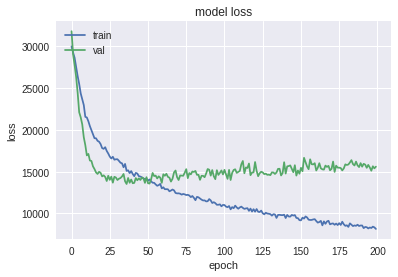

In [ ]:
K.clear_session()
dropout_rate = 0.5
model = Sequential()
model.add(GRU(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate, return_sequences = True))
model.add(GRU(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate, return_sequences = True))
model.add(GRU(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate, return_sequences = True))
model.add(GRU(256, input_shape=(lookback+1, 96), 
               dropout=dropout_rate))
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(dropout_rate))
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(dropout_rate))
model.add(Dense(500, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(250, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

history = model.fit(X_train_rnn, y_train_rnn,
          epochs=200, batch_size=512*2,validation_split= 0.1, verbose=1)
#           ,callbacks=[early_stop])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


The mean square error of cursor position: 2289.3401118596817


(-150, 150)

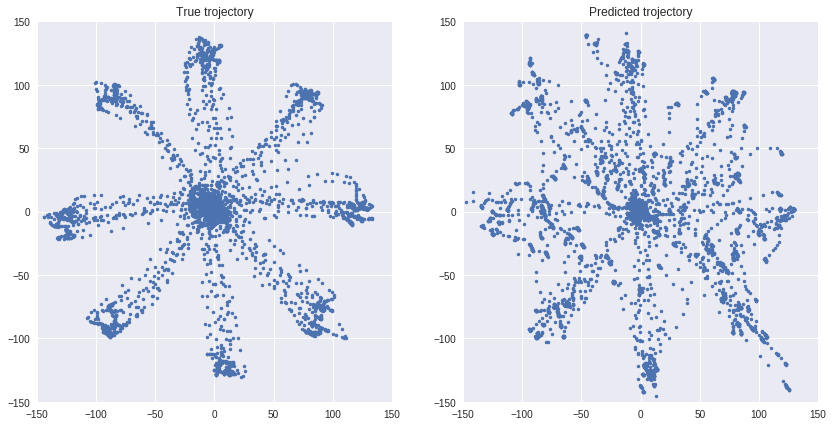

In [ ]:
plt.figure(figsize=(7,7))

X_bin_poss = np.empty((2,0))
X_bin_pos_hats = np.empty((2,0))
test_num = 106
pos_errors = []

for i in range(test_num):
  X = R[train_num + i]['cursorPos']
  X = scipy.sparse.csc_matrix(X)
  X_bin_pos = bin(X, dt,'first')
  X_bin_v = np.matrix(np.diff(X_bin_pos[0:2,:])/dt*1000, dtype = 'float')

  num_bin = X_bin_pos.shape[1]
  X_bin_pos = X_bin_pos[0:2,0:num_bin]
  if X.shape[1]%dt == 0:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin]])
  else:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin-1]])
  
  Y = R[train_num+i]['spikeRaster']
  Y_bin = bin(Y, dt,'sum')
  pre_Y = R[train_num-1+i]['spikeRaster']
  pre_Y_bin = bin(pre_Y, dt,'sum')

  X_test_rnn, _ = reformatinginput_for_rnn(Y_bin, X_bin_v, 3, pre_Y_bin)

  X_bin_v_hat = model.predict(X_test_rnn)
  X_bin_v_hat = X_bin_v_hat.T
  num_bins = X_bin_v_hat.shape[1]
  X_bin_pos_hat = np.empty((2,num_bins+1))

  X_bin_pos_hat[:,0] = R[train_num+i]['cursorPos'][0:2,0]
  for j in range(num_bins):
    X_bin_pos_hat[:,j+1] = X_bin_pos_hat[:,j] + \
                  0.025*np.array(X_bin_v_hat[0:2,j]).flatten()
  X_bin_pos_hat
  X_bin_pos_hats = np.hstack([X_bin_pos_hats, X_bin_pos_hat[:,0:num_bins]])

  diff_trial = (X_bin_pos[:,0:num_bin] - X_bin_pos_hat[:,0:num_bin])
  pos_errors.append(np.mean(np.sum(np.power(diff_trial,2),axis = 0)))
print("The mean square error of cursor position: {}".format(np.mean(pos_errors)))

  
  
f, axs = plt.subplots(1,2,figsize=(14,7))
axs[0].plot(X_bin_poss[0,:],X_bin_poss[1,:], '.')
axs[0].set_title('True trojectory')
axs[0].set_xlim([-150, 150])
axs[0].set_ylim([-150, 150])

axs[1].plot(X_bin_pos_hats[0,:],X_bin_pos_hats[1,:], '.')
axs[1].set_title('Predicted trojectory')
axs[1].set_xlim([-150, 150])
axs[1].set_ylim([-150, 150])
